In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

import pymc3 as pm

In [8]:
dat = pd.read_csv('WaffleDivorce.csv', sep=';')

In [9]:
age_std = (dat['MedianAgeMarriage']-dat['MedianAgeMarriage'].mean())/dat['MedianAgeMarriage'].std()
div_std = (dat['Divorce']-dat['Divorce'].mean())/dat['Divorce'].std()
mar_std = (dat['Marriage']-dat['Marriage'].mean())/dat['Marriage'].std()

## Model to predict divorce rate given age at marriage

In [10]:
with pm.Model() as model_div_age:
    alpha   = pm.Normal('alpha', mu=0, sd=0.2)
    beta    = pm.Normal('beta', mu=0, sigma=0.5)
    sigma   = pm.Exponential('sigma', lam=1)
    divorce = pm.Normal('divorce', mu=alpha + beta*age_std, sd=sigma, observed=div_std)
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])
    
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=111)

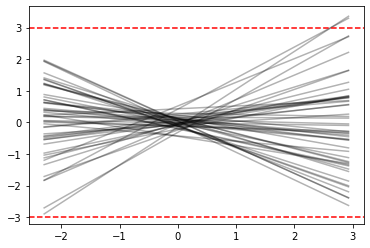

In [11]:
for a, b in zip(prior_checks['alpha'], prior_checks['beta']):
    _ = plt.plot([age_std.min(), age_std.max()], [a+b*age_std.min(), a+b*age_std.max()], color='k', alpha=0.3)
    
plt.axhline(3, linestyle='--', color='r')
plt.axhline(-3, linestyle='--', color='r')

#plt.savefig('check_prior_D_give_A.png', transparent=True)

In [12]:
st_dev = np.diag(np.linalg.inv(hessian))**0.5

In [13]:
age_min = dat['MedianAgeMarriage'].min()
age_max = dat['MedianAgeMarriage'].max()

age_seq = np.linspace(age_min, age_max)

sample_alpha = norm.rvs(size=10**4, loc=par_post['alpha'], scale=st_dev[0])
sample_beta  = norm.rvs(size=10**4, loc=par_post['beta'],  scale=st_dev[1])
sample_sigma = norm.rvs(size=10**4, loc=par_post['sigma'], scale=st_dev[2])

In [14]:
stan_age = (age_min-dat['MedianAgeMarriage'].mean())/dat['MedianAgeMarriage'].std()

ConfidenceIntervals = pd.DataFrame(
    np.quantile((sample_alpha + sample_beta * stan_age)*dat['Divorce'].std()+dat['Divorce'].mean(),
                [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [15]:
for i in range(1, len(age_seq)):
    stan_age = (age_seq[i]-dat['MedianAgeMarriage'].mean())/dat['MedianAgeMarriage'].std()
    
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile((sample_alpha + sample_beta * stan_age)*dat['Divorce'].std()+dat['Divorce'].mean(),
                         [0.025, 0.975]).reshape(1,2), columns=['LCI', 'UCI']
         )
        ]
    )

In [16]:
ConfidenceIntervals['age'] = age_seq

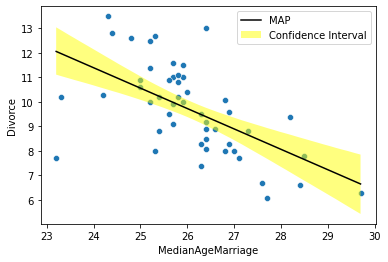

In [17]:
sns.scatterplot(data=dat, x='MedianAgeMarriage', y='Divorce')

plt.plot([age_min, age_max],
        [(par_post['alpha'] + par_post['beta']*age_std.min())*dat['Divorce'].std()+dat['Divorce'].mean(),
         (par_post['alpha'] + par_post['beta']*age_std.max())*dat['Divorce'].std()+dat['Divorce'].mean()], color='k', label='MAP')

plt.fill_between(ConfidenceIntervals['age'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.legend()

#plt.savefig('D_given_A.png', transparent=True)

In [18]:
beta_age_interval_model1 = np.quantile(sample_beta,0.025), np.quantile(sample_beta,0.975)

In [19]:
par_post['beta']

array(-0.5684035)

In [20]:
beta_age_interval_model1

(-0.7884276937963027, -0.35620135479148785)

## Model to predict divorce rate given marriage rate

In [21]:
with pm.Model() as model_div_mar:
    alpha   = pm.Normal('alpha', mu=0, sd=0.2)
    beta    = pm.Normal('beta', mu=0, sigma=0.5)
    sigma   = pm.Exponential('sigma', lam=1)
    divorce = pm.Normal('divorce', mu=alpha + beta*mar_std, sd=sigma, observed=div_std)
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])
    
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=111)

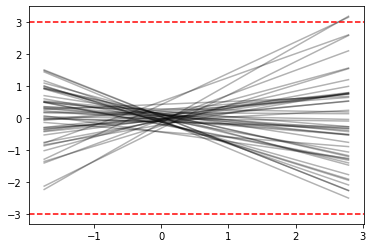

In [22]:
for a, b in zip(prior_checks['alpha'], prior_checks['beta']):
    _ = plt.plot([mar_std.min(), mar_std.max()], [a+b*mar_std.min(), a+b*mar_std.max()], color='k', alpha=0.3)
    
plt.axhline(3, linestyle='--', color='r')
plt.axhline(-3, linestyle='--', color='r')

In [23]:
st_dev = np.diag(np.linalg.inv(hessian))**0.5

In [24]:
mar_min = dat['Marriage'].min()
mar_max = dat['Marriage'].max()

mar_seq = np.linspace(mar_min, mar_max)

sample_alpha = norm.rvs(size=10**4, loc=par_post['alpha'], scale=st_dev[0])
sample_beta  = norm.rvs(size=10**4, loc=par_post['beta'],  scale=st_dev[1])
sample_sigma = norm.rvs(size=10**4, loc=par_post['sigma'], scale=st_dev[2])

In [25]:
stan_mar = (mar_min-dat['Marriage'].mean())/dat['Marriage'].std()

ConfidenceIntervals = pd.DataFrame(
    np.quantile((sample_alpha + sample_beta * stan_mar)*dat['Divorce'].std()+dat['Divorce'].mean(),
                [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [26]:
for i in range(1, len(mar_seq)):
    stan_mar = (mar_seq[i]-dat['Marriage'].mean())/dat['Marriage'].std()
    
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile((sample_alpha + sample_beta * stan_mar)*dat['Divorce'].std()+dat['Divorce'].mean(),
                         [0.025, 0.975]).reshape(1,2), columns=['LCI', 'UCI']
         )
        ]
    )

In [27]:
ConfidenceIntervals['marriage'] = mar_seq

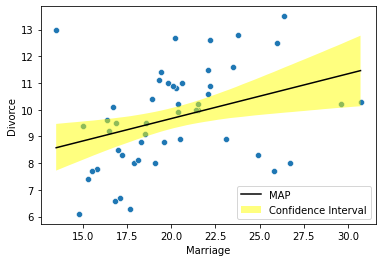

In [28]:
sns.scatterplot(data=dat, x='Marriage', y='Divorce')

plt.plot([mar_min, mar_max],
        [(par_post['alpha'] + par_post['beta']*mar_std.min())*dat['Divorce'].std()+dat['Divorce'].mean(),
         (par_post['alpha'] + par_post['beta']*mar_std.max())*dat['Divorce'].std()+dat['Divorce'].mean()], color='k', label='MAP')

plt.fill_between(ConfidenceIntervals['marriage'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.legend()

#plt.savefig('D_given_M.png', transparent=True)

In [29]:
beta_mar_interval_model2 = np.quantile(sample_beta,0.025), np.quantile(sample_beta,0.975)

In [30]:
par_post['beta']

array(0.35005398)

In [31]:
beta_mar_interval_model2

(0.09817071872422453, 0.592982576905059)

## Model to predict marriage rate given median age at marriage

In [32]:
with pm.Model() as model_mar_given_age:
    alpha    = pm.Normal('alpha', mu=0, sd=0.2)
    beta     = pm.Normal('beta', mu=0, sigma=0.5)
    sigma    = pm.Exponential('sigma', lam=1)
    marriage = pm.Normal('marriage', mu=alpha + beta*age_std, sd=sigma, observed=mar_std)
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])
    
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=111)

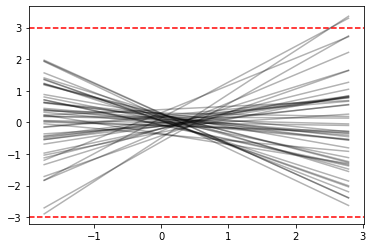

In [33]:
for a, b in zip(prior_checks['alpha'], prior_checks['beta']):
    _ = plt.plot([mar_std.min(), mar_std.max()], [a+b*age_std.min(), a+b*age_std.max()], color='k', alpha=0.3)
    
plt.axhline(3, linestyle='--', color='r')
plt.axhline(-3, linestyle='--', color='r')

In [34]:
st_dev = np.diag(np.linalg.inv(hessian))**0.5

In [35]:
age_min = age_std.min()
age_max = age_std.max()

age_seq = np.linspace(age_min, age_max)

sample_alpha = norm.rvs(size=10**4, loc=par_post['alpha'], scale=st_dev[0])
sample_beta  = norm.rvs(size=10**4, loc=par_post['beta'],  scale=st_dev[1])
sample_sigma = norm.rvs(size=10**4, loc=par_post['sigma'], scale=st_dev[2])

In [36]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(sample_alpha + sample_beta * age_min, [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [37]:
for i in range(1, len(age_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(np.quantile(sample_alpha + sample_beta * age_seq[i], [0.025, 0.975]).reshape(1,2), columns=['LCI', 'UCI'])])

In [38]:
ConfidenceIntervals['age_std'] = age_seq

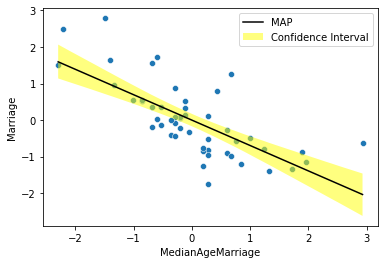

In [39]:
sns.scatterplot(x=age_std, y=mar_std)

plt.plot([age_min, age_max],
         [par_post['alpha'] + par_post['beta']*age_std.min(),
          par_post['alpha'] + par_post['beta']*age_std.max()], color='k', label='MAP')

plt.fill_between(ConfidenceIntervals['age_std'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.legend()

#plt.savefig('M_given_A.png', transparent=True)

In [40]:
resid_mar_given_age = mar_std - (par_post['alpha'] + par_post['beta']*age_std)

In [41]:
par_post['beta']

array(-0.69473769)

## About DAGs

We have checked that there is a relation pairwise between the variables. So we can think in the SCM associated to the graph: $D \leftarrow A \rightarrow M$ and $M \rightarrow D$.

However, in the first model we have accounted the total effect of $A$ over $D$. The "total" means that we have accounted for every path from $A$ to $D$. there are two such paths $A \rightarrow D$, a direct path, and $A \rightarrow M \rightarrow D$, an indirect path.

In general, it is possible that the variable A has no direct effect at all on D. It could be associated with D entirely through the indirect path $A \rightarrow M \rightarrow D$. In such case $M$ is called a Mediator.

Also, in principle, it is also possible that the variable $M$ has no direct effect on $D$. It could be associated with $D$ entirely through the indirect path $M \leftarrow A \rightarrow D$. In such case $A$ is called a Confounder. However from the simple inspection of the problem we can conclude that this path does exits.

### Let's infere the correct causal model

In [42]:
with pm.Model() as model_mar_given_age:
    alpha    = pm.Normal('alpha', mu=0, sd=0.2)
    beta_M   = pm.Normal('beta_M', mu=0, sigma=0.5)
    beta_A   = pm.Normal('beta_A', mu=0, sigma=0.5)
    sigma    = pm.Exponential('sigma', lam=1)
    divorce  = pm.Normal('divorce', mu=alpha + beta_M*mar_std + beta_A*age_std, sd=sigma, observed=div_std)
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta_M, beta_A, sigma])

In [43]:
st_dev = np.diag(np.linalg.inv(hessian))**0.5

sample_alpha  = norm.rvs(size=10**4, loc=par_post['alpha'],  scale=st_dev[0])
sample_beta_M = norm.rvs(size=10**4, loc=par_post['beta_M'], scale=st_dev[1])
sample_beta_A = norm.rvs(size=10**4, loc=par_post['beta_A'], scale=st_dev[2])
sample_sigma  = norm.rvs(size=10**4, loc=par_post['sigma'],  scale=st_dev[3])

In [44]:
beta_age_interval_model3 = np.quantile(sample_beta_A,0.025), np.quantile(sample_beta_A,0.975)
beta_mar_interval_model3 = np.quantile(sample_beta_M,0.025), np.quantile(sample_beta_M,0.975)

### Let's compare the intervals of the parameters for the different models

In [45]:
np.round(beta_age_interval_model1, 2)

array([-0.79, -0.36])

In [46]:
np.round(beta_age_interval_model3, 2)

array([-0.9 , -0.31])

In [47]:
np.round(beta_mar_interval_model2, 2)

array([0.1 , 0.59])

In [48]:
np.round(beta_mar_interval_model3, 2)

array([-0.36,  0.23])

The correlation parameter associated to the age does not show important differences. But, the parameter associated to the marriage rate is really affected, and now the credible interval includes the zero. That is given the age, the marriage rate is irrelevant for the divorce rate, $D \_||\_ M | A$. That is possitive evidence for the confounder causal model: $D \leftarrow A \rightarrow M.$

### Using the residual plots to infere causation

Previously, we fitted the model A -> M, if the confounded model is correct, then the residuals should not be correlated wih the divorce rate. Let's check this assumption.

## Model to predict the divorce rate given the residuals of marriage given age

In [49]:
with pm.Model() as model_div_given_resid_mar:
    alpha    = pm.Normal('alpha', mu=0, sd=0.2)
    beta     = pm.Normal('beta', mu=0, sigma=0.5)
    sigma    = pm.Exponential('sigma', lam=1)
    divorce  = pm.Normal('divorce', mu=alpha + beta*resid_mar_given_age, sd=sigma, observed=div_std)
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])

In [50]:
st_dev = np.diag(np.linalg.inv(hessian))**0.5

sample_alpha = norm.rvs(size=10**4, loc=par_post['alpha'], scale=st_dev[0])
sample_beta  = norm.rvs(size=10**4, loc=par_post['beta'],  scale=st_dev[1])
sample_sigma = norm.rvs(size=10**4, loc=par_post['sigma'], scale=st_dev[2])

In [51]:
resid_min = resid_mar_given_age.min()
resid_max = resid_mar_given_age.max()

resid_seq = np.linspace(resid_min, resid_max)

In [52]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(sample_alpha + sample_beta * resid_min, [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [53]:
for i in range(1, len(resid_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(np.quantile(sample_alpha + sample_beta * resid_seq[i], [0.025, 0.975]).reshape(1,2), columns=['LCI', 'UCI'])])

In [54]:
ConfidenceIntervals['residuals'] = resid_seq

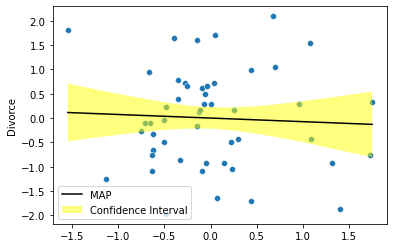

In [55]:
sns.scatterplot(x=resid_mar_given_age, y=div_std)

plt.plot([resid_min, resid_max],
         [par_post['alpha'] + par_post['beta']*resid_min,
          par_post['alpha'] + par_post['beta']*resid_max], color='k', label='MAP')

plt.fill_between(ConfidenceIntervals['residuals'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.legend()

#plt.savefig('D_given_resid_M.png', transparent=True)

In [56]:
np.round(par_post['beta'],2)

-0.07

## Model to predict age at marriage given marriage rate

In [57]:
with pm.Model() as model_age_given_mar:
    alpha = pm.Normal('alpha', mu=0, sd=0.2)
    beta  = pm.Normal('beta', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    age   = pm.Normal('age', mu=alpha + beta*mar_std, sd=sigma, observed=age_std)
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])
    
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=111)

In [58]:
st_dev = np.diag(np.linalg.inv(hessian))**0.5

In [59]:
mar_min = mar_std.min()
mar_max = mar_std.max()

mar_seq = np.linspace(mar_min, mar_max)

sample_alpha = norm.rvs(size=10**4, loc=par_post['alpha'], scale=st_dev[0])
sample_beta  = norm.rvs(size=10**4, loc=par_post['beta'],  scale=st_dev[1])
sample_sigma = norm.rvs(size=10**4, loc=par_post['sigma'], scale=st_dev[2])

In [60]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(sample_alpha + sample_beta * mar_min, [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [61]:
for i in range(1, len(age_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(np.quantile(sample_alpha + sample_beta * mar_seq[i], [0.025, 0.975]).reshape(1,2), columns=['LCI', 'UCI'])])

In [62]:
ConfidenceIntervals['mar_std'] = mar_seq

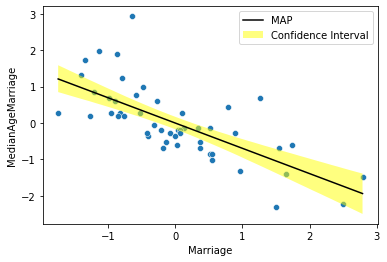

In [63]:
sns.scatterplot(x=mar_std, y=age_std)

plt.plot([mar_min, mar_max],
         [par_post['alpha'] + par_post['beta']*mar_min,
          par_post['alpha'] + par_post['beta']*mar_max], color='k', label='MAP')

plt.fill_between(ConfidenceIntervals['mar_std'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.legend()

#plt.savefig('A_given_M.png', transparent=True)

In [64]:
np.round(par_post['beta'],2)

-0.69

In [65]:
resid_age_given_mar = age_std - (par_post['alpha'] + par_post['beta']*mar_std)

## Model to predict the divorce rate given the residuals of age given marriage

In [66]:
with pm.Model() as model_div_given_resid_age:
    alpha    = pm.Normal('alpha', mu=0, sd=0.2)
    beta     = pm.Normal('beta', mu=0, sigma=0.5)
    sigma    = pm.Exponential('sigma', lam=1)
    divorce  = pm.Normal('divorce', mu=alpha + beta*resid_age_given_mar, sd=sigma, observed=div_std)
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta, sigma])

In [67]:
st_dev = np.diag(np.linalg.inv(hessian))**0.5

sample_alpha = norm.rvs(size=10**4, loc=par_post['alpha'], scale=st_dev[0])
sample_beta  = norm.rvs(size=10**4, loc=par_post['beta'],  scale=st_dev[1])
sample_sigma = norm.rvs(size=10**4, loc=par_post['sigma'], scale=st_dev[2])

In [68]:
resid_min = resid_age_given_mar.min()
resid_max = resid_age_given_mar.max()

resid_seq = np.linspace(resid_min, resid_max)

In [69]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(sample_alpha + sample_beta * resid_min, [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [70]:
for i in range(1, len(resid_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(np.quantile(sample_alpha + sample_beta * resid_seq[i], [0.025, 0.975]).reshape(1,2), columns=['LCI', 'UCI'])])

In [71]:
ConfidenceIntervals['residuals'] = resid_seq

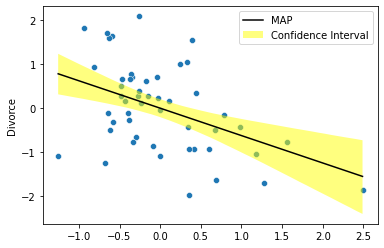

In [72]:
sns.scatterplot(x=resid_age_given_mar, y=div_std)

plt.plot([resid_min, resid_max],
         [par_post['alpha'] + par_post['beta']*resid_min,
          par_post['alpha'] + par_post['beta']*resid_max], color='k', label='MAP')

plt.fill_between(ConfidenceIntervals['residuals'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')

plt.legend()

#plt.savefig('D_given_resid_A.png', transparent=True)

In [73]:
np.round(par_post['beta'],2)

-0.62

Thus, we can conclude that the confounded path has stronger correlations that the mediation path.